## Designing a CNN for Human Activity Recognition (HAR)

- Why is a CNN good for HAR?

## Initial pre-processing of the Activity Prediction dataset

- some background : Kwapisz and Weiss 2010 

In [77]:
import pandas as pd 

data_path = 'WISDM_ar_v1.1\\WISDM_ar_v1.1_raw.txt'

field_names = ['user', 'activity', 'timestamp', 'x-accel', 'y-accel', 'z-accel'] # Derived from about file of raw data
df = pd.read_csv(filepath_or_buffer=data_path, delimiter=',', lineterminator=';', names=field_names)

c:\users\carlo\desktop\grad\2-winter2019\ee239as\hw1\.env\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [78]:
df.head()

,user,activity,timestamp,x-accel,y-accel,z-accel
0,33,Jogging,4.910596e+13,-0.694638,12.680544,0.503953
1,33,Jogging,4.910606e+13,5.012288,11.264028,0.953424
2,33,Jogging,4.910611e+13,4.903325,10.882658,-0.081722
3,33,Jogging,4.910622e+13,-0.612916,18.496431,3.023717
4,33,Jogging,4.910633e+13,-1.184970,12.108489,7.205164


user: unique ID for each user that's contributed sensor data to the experiment. Can be used to distinguish between users doing the same activity for another project.

activity: 1 of the 6 activities subjects recorded. Consisting of 'Jogging', 'Walking', 'Sitting', 'Standing', 'Upstairs' (for walking upstairs), and 'Downstairs'. For the project, we only care about 'Jogging', 'Walking', and 'Sitting'. 

timestamp: the phone's uptime in nanoseconds. All the data in the dataset was sampled at 20 Hz, so 20 samples make up a second's worth of information and sensor readings were sampled every 50 ms.

xyz-accel: phone's acceleration along the respective access (see below for more on phone's actual orientation during data acquisition). A value of 10 of these features is 1g, or 9.81 m/s squared. Earth's gravitational force is accounted for by the accelerometer.
    
    

In [79]:
df.tail()

,user,activity,timestamp,x-accel,y-accel,z-accel
1098204,\r\n19,Sitting,1.316234e+14,9.04,-1.46,1.73
1098205,\r\n19,Sitting,1.316234e+14,9.08,-1.38,1.69
1098206,\r\n19,Sitting,1.316235e+14,9.00,-1.46,1.73
1098207,\r\n19,Sitting,1.316235e+14,8.88,-1.33,1.61
1098208,\r\n\r\n,NaN,NaN,NaN,NaN,NaN


In [80]:
df['user'].unique()

array([33, 17, 20, 29, 13, 15, 6, 27, 36, 18, 32, 35, 11, 16, 5, 10, 28,
       26, 14, 24, 12, 23, 4, 30, 34, 8, 31, 21, 3, 22, 1, 9, 25, 2, 7,
       '\r\n7', '\r\n19', '\r\n\r\n'], dtype=object)

Some user IDs got deformed while reading the text file into a dataframe. Let's clean it up.

In [81]:
df.loc[df['user'] == '\r\n7', 'user'] = 7
df.loc[df['user'] == '\r\n19', 'user'] = 19
df.drop(df.tail(1).index,inplace=True) # Drop last row

In [82]:
df.tail()

,user,activity,timestamp,x-accel,y-accel,z-accel
1098203,19,Sitting,1.316233e+14,9.00,-1.57,1.69
1098204,19,Sitting,1.316234e+14,9.04,-1.46,1.73
1098205,19,Sitting,1.316234e+14,9.08,-1.38,1.69
1098206,19,Sitting,1.316235e+14,9.00,-1.46,1.73
1098207,19,Sitting,1.316235e+14,8.88,-1.33,1.61


In [83]:
df['user'].unique()

array([33, 17, 20, 29, 13, 15, 6, 27, 36, 18, 32, 35, 11, 16, 5, 10, 28,
       26, 14, 24, 12, 23, 4, 30, 34, 8, 31, 21, 3, 22, 1, 9, 25, 2, 7,
       19], dtype=object)

Now that the data set has been successfully read into a dataframe, let's start poking around.

The star of the show is the accelerometer data in 3 dimensions. However, we have to know what kind of motion each axis attempted to capture to know how to orient the phone so that the model trained by this data can be applicable. The researchers at Fordham University that collected the data say that "the z-axis captures the forward movement of the leg and the y-axis captures the upward and downward motion. The x-axis captures horizontal movement of the user’s leg." [1]

Further, the same paper mentions that the data was recorded with a smartphone lying in a user's front leg pocket, where it may commonly reside during everyday tasks and exercise.

In [84]:
import numpy as np 

def standardize(feature):
    # Standardize the features by centering their means at 0 and making their standard deviation 1
    mean = np.mean(feature, axis=0)
    std = np.std(feature, axis=0)
    return (feature - mean)/std


In [85]:
df['x-accel'] = standardize(df['x-accel'])
df['y-accel'] = standardize(df['y-accel'])
df['z-accel'] = standardize(df['z-accel'])

In [86]:
df.head() # Check newly-standardized values

,user,activity,timestamp,x-accel,y-accel,z-accel
0,33,Jogging,4.910596e+13,-0.198203,0.804143,0.019535
1,33,Jogging,4.910606e+13,0.635041,0.594171,0.114079
2,33,Jogging,4.910611e+13,0.619132,0.537640,-0.103658
3,33,Jogging,4.910622e+13,-0.186271,1.666240,0.549552
4,33,Jogging,4.910633e+13,-0.269795,0.719347,1.429094


## Exploring the dataset

Now that the data is ready to be worked with, let's check some basic statistics of the set.

In [87]:
# How much data did each user collect? (in samples. From this you can find the amount in time)
df_user_distribution = df.groupby('user').size() 

# How many samples of each activity are there? (is the dataset balanced? Would be ideal for training)
df_activity_distribution = df.groupby('activity').size() 


Text(0, 0.5, 'samples')

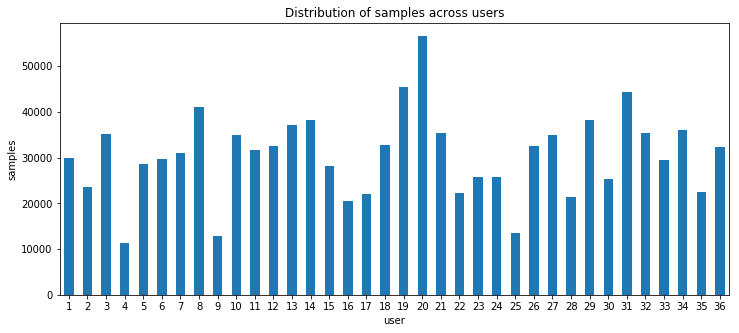

In [88]:
ax_ud = df_user_distribution.plot(kind='bar', rot=0, figsize=(12,5), title='Distribution of samples across users')
ax_ud.set_xlabel('user')
ax_ud.set_ylabel('samples')

For the most part, users spent the same amount of time collecting data. While identifying users by their activity accelerometer data is not the focus of this project, it may be something to look into in the future!

Text(0, 0.5, 'samples')

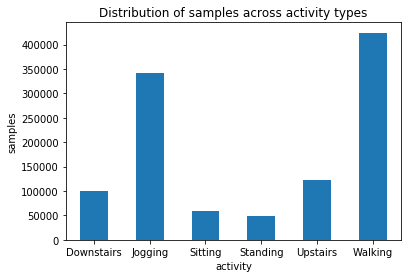

In [89]:
ax_ad = df_activity_distribution.plot(kind='bar', rot=0, title='Distribution of samples across activity types')
ax_ad.set_xlabel('activity')
ax_ad.set_ylabel('samples')

The dataset split across activities is imbalanced. While 2 of the 3 activity types focused on in this project (Walking and Jogging) are both relatively plentiful and balanced, the same can't be said for the Sitting activity.

To quantify it with more granularity:

In [90]:
num_entries = df_activity_distribution.sum()

df_activity_distribution.keys()
df_activity_distribution['Downstairs']
for activity in df_activity_distribution.keys():
    print('%s \t%.1f%%' % (activity, df_activity_distribution[activity]*100/num_entries))

Downstairs 	9.1%
Jogging 	31.2%
Sitting 	5.5%
Standing 	4.4%
Upstairs 	11.2%
Walking 	38.6%


Let's now visualize the data and see if any assumptions we may hold about how the data might look for different activities seem to hold (i.e. for walking, we expect to see lower magnitude of acceleration than jogging).

In [91]:
import matplotlib.pyplot as plt 

def plot_slice(dataframe, activity, slice_start=0, slice_size=60):
    # Plot slice_size-slice_start samples of each axis of accelerometer data
    # By default, plot 3 seconds (60 samples)
    
    dataframe = dataframe[dataframe['activity'] == activity][slice_start:slice_size]
    fig, axes = plt.subplots(nrows=4, sharex=True, figsize=(15,10))
    timestamps = dataframe['timestamp']
    accels = [dataframe['x-accel'], dataframe['y-accel'], dataframe['z-accel']]
    titles = ['X-axis sensor readings (' + activity + ')', 
              'Y-axis sensor readings (' + activity + ')', 
              'Z-axis sensor readings (' + activity + ')']
    
    i = 0
    for ax in axes[:-1]:
        ax.plot(timestamps, accels[i])
        ax.set_title(titles[i])
        ax.grid(True)
        ax.set_ylim([-2.5, 2.5]) # 2.5x the standard deviation 
        i += 1
        
    axes[-1].plot(timestamps, accels[0])
    axes[-1].plot(timestamps, accels[1])
    axes[-1].plot(timestamps, accels[2])
    axes[-1].set_title('All axes\' sensor readings (' + activity + ')')
    axes[-1].grid(True)
    axes[-1].set_ylim([-2.5, 2.5]) # 2.5x the standard deviation 
    axes[-1].set_xlabel('Uptime in nanoseconds')
    axes[-1].legend()
    
    
    plt.tight_layout()
    plt.show()

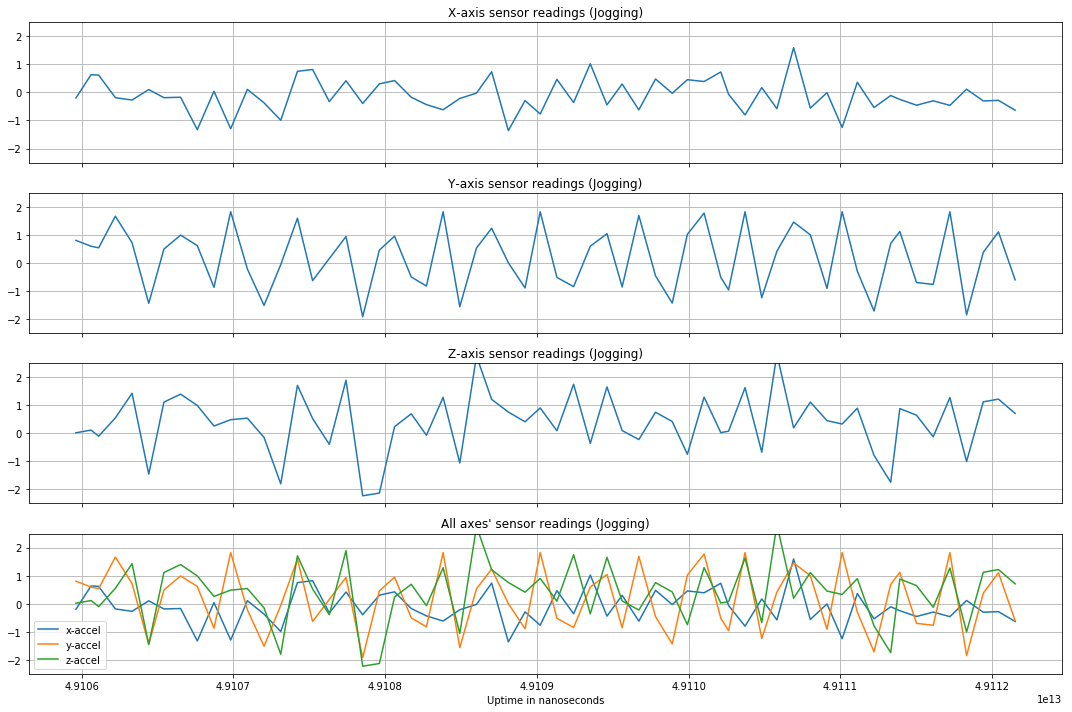

In [92]:
plot_slice(df, 'Jogging')

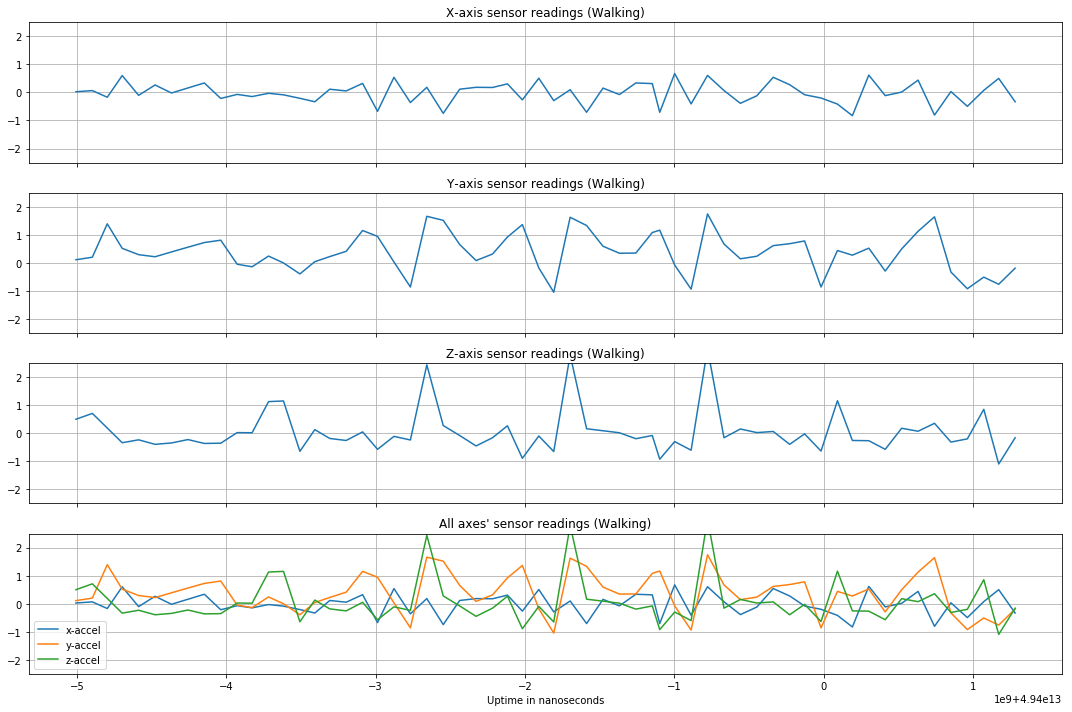

In [93]:
plot_slice(df, 'Walking')

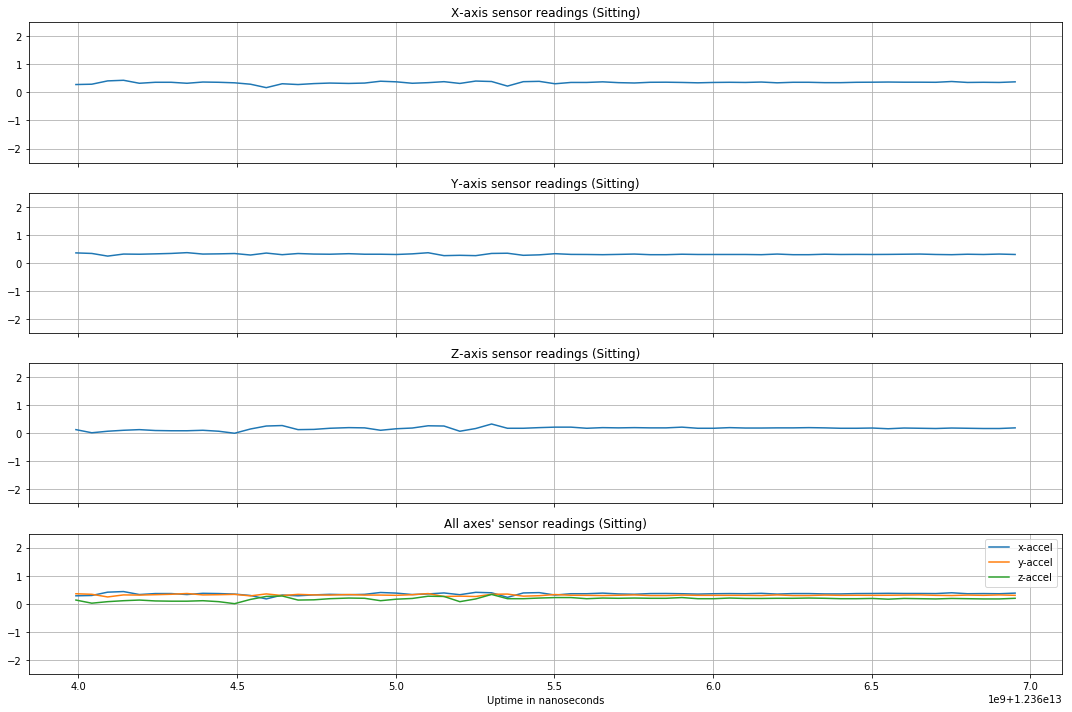

In [94]:
plot_slice(df, 'Sitting')

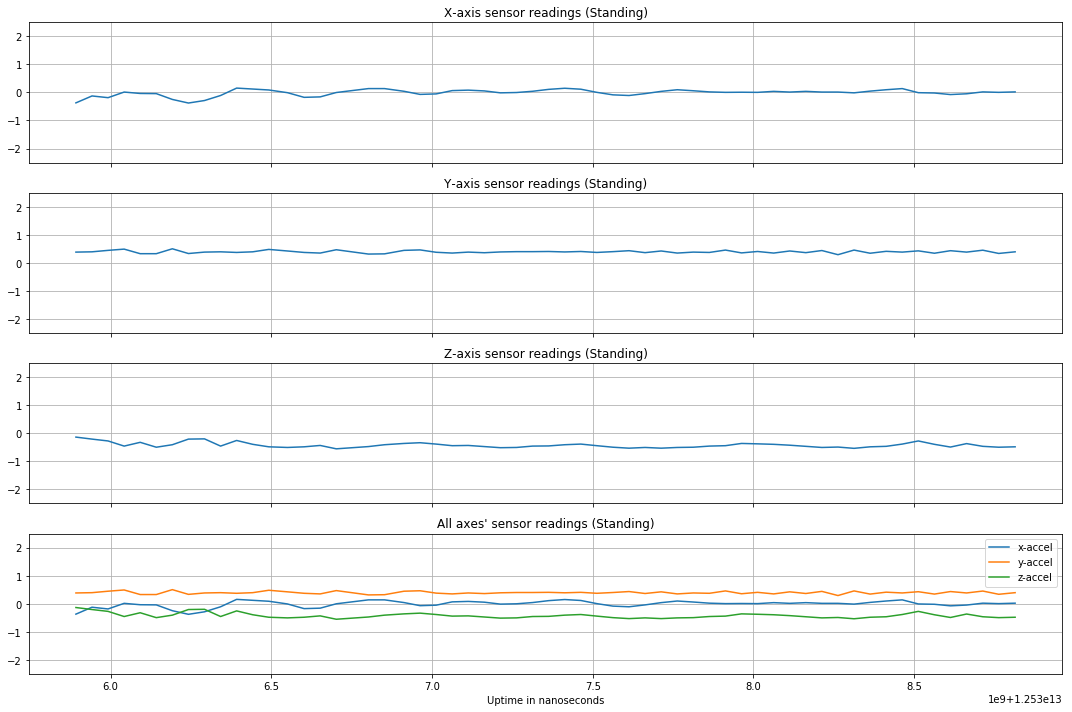

In [95]:
plot_slice(df, 'Standing')

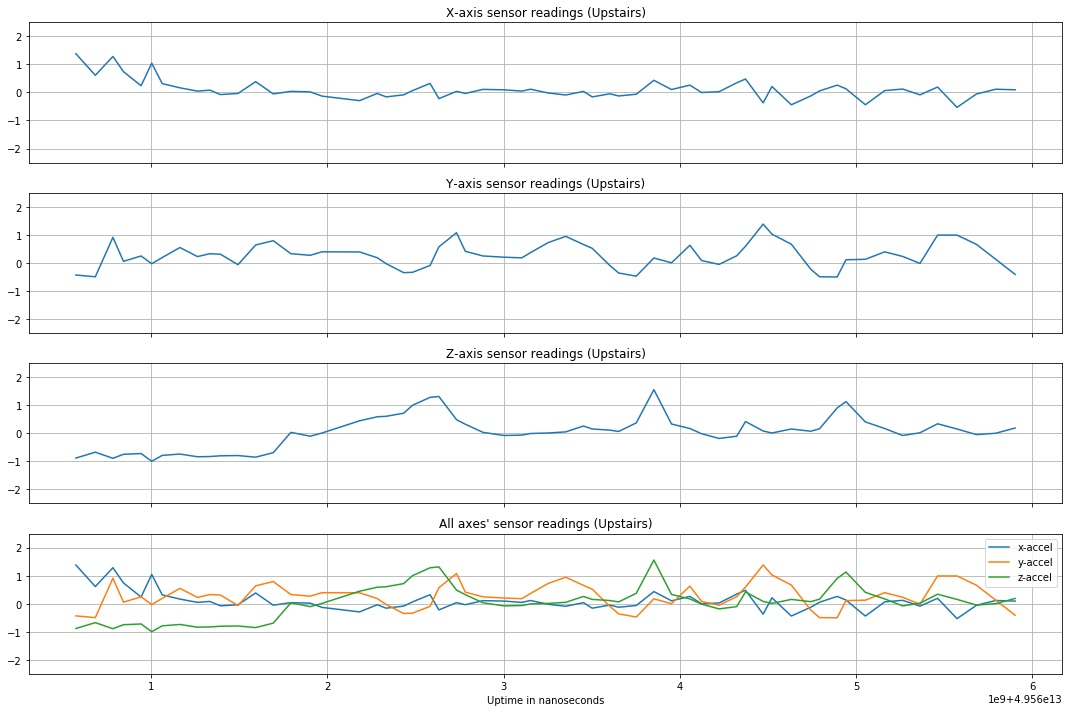

In [136]:
plot_slice(df, 'Upstairs')

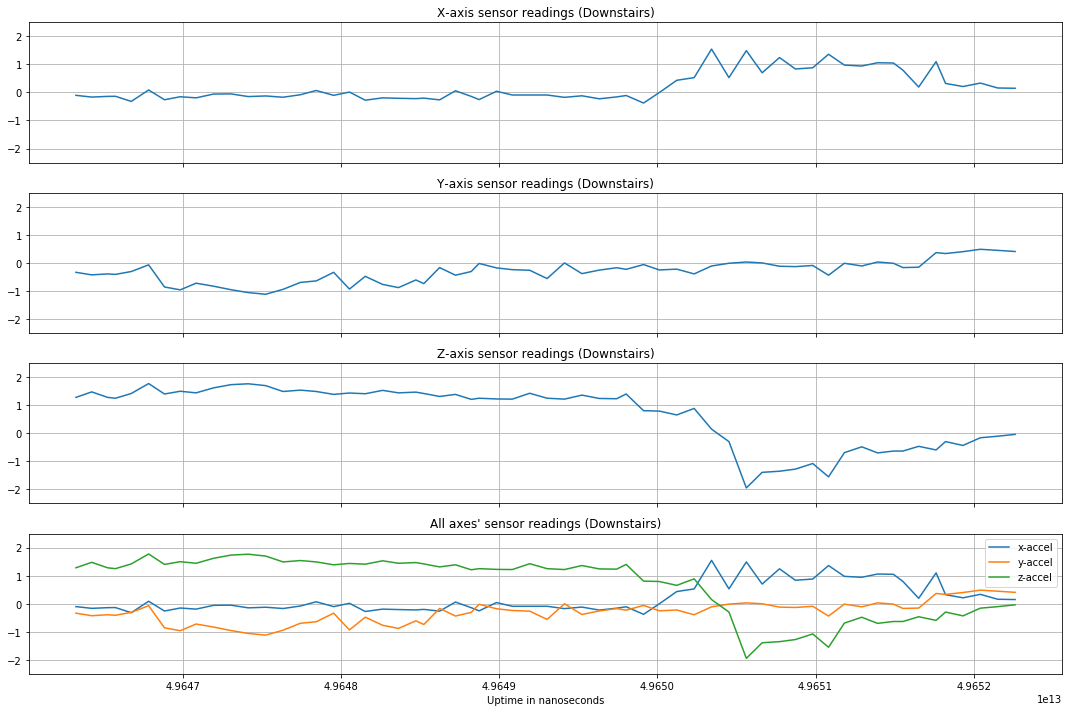

In [137]:
plot_slice(df, 'Downstairs')

As expected, the most vigorous of the 3 activities, jogging, has the most acceleration over each of the axes. (and the period between spikes in acceleration is smaller) Following that, sitting has by far the least acceleration in any of the axes and can be interpreted to be either aperiodic or to have the longest period among the activities. Walking sits between these two extremes.

## More pre-processing: Getting the data ready for a CNN

Now that we've done some basic exploration of the dataset, it's time to prepare the data in such a way that it's readily digestible by a CNN.

To feed this data to a CNN, the data must first be partitioned into windows, i.e. time slices of samples. Each window will have its respective label for classification. The windows of data represent snapshots of sensor activity that are meant to capture what that activity looks like in terms of sensor data. So each window should have an associated label for its respective activity. 

Two hyperparameters get introduced: the window size and the amount of window overlap. For example, we can choose window sizes of 6 seconds (120 samples) and no overlap - this would make it so that each window has fresh, new data. However, if overlap is changed to 50%, then the first 50% of each window would consist of the previous window and the last 50% would be new data (only 3 seconds of new data). 

Thankfully the data is organized in chronological order for each user so taking slices in order of index is congruent with time.

In [96]:
import numpy as np

def to_windows(dataframe, activity, window_size=60, overlap=0.0):
    # Input: 
    # dataframe - raw data from the Activity Prediction dataset as a dataframe
    # activity - activity key e.g. 'Sitting' or 'Jogging'
    # window_size - the number of samples to make each window out of
    # overlap - accepts from 0.0 to 0.9
    
    # Output:
    # windows - numpy array of the windows, size 3 x window_size x number_of_windows
    
    if overlap < 0.0 or overlap > 0.9:
        return False
        
    df_activity = dataframe.loc[dataframe['activity'] == activity]
    users = df_activity['user'].unique()
    step = int(window_size*(1-overlap))
    
    all_windows = np.zeros((window_size,3,0)) # hstack new windows for each user onto this
    
    for user in users:
        # Extract samples per user for this activity, call it a session
        session = df_activity.loc[df_activity['user'] == user]
        session_samples = len(session.index)
        number_of_windows = int(session_samples // (window_size * (1-overlap))) - 1
        
        for i in range(number_of_windows):
            if i == 0:
                this_window = np.array((session.iloc[i:window_size]['x-accel'],
                              session.iloc[i:window_size]['y-accel'],
                              session.iloc[i:window_size]['z-accel'])).T
            else:
                start = i*(window_size-step)
                stop = i*(window_size-step) + window_size
                this_window = np.array((session.iloc[start:stop]['x-accel'],
                                        session.iloc[start:stop]['y-accel'],
                                        session.iloc[start:stop]['z-accel'])).T
                
            all_windows = np.dstack((all_windows, this_window))
            
            
        
    return all_windows # shape: window_size * 3 * number of windows    
    

In [138]:
# Start with 3 second windows, no overlap
window_size = 60 
overlap = 0.0
num_activity_types = 6

sitting_data = to_windows(df, 'Sitting', window_size=window_size, overlap=overlap)
walking_data = to_windows(df, 'Walking', window_size=window_size, overlap=overlap)
jogging_data = to_windows(df, 'Jogging', window_size=window_size, overlap=overlap)
standing_data = to_windows(df, 'Standing', window_size=window_size, overlap=overlap)
upstairs_data = to_windows(df, 'Upstairs', window_size=window_size, overlap=overlap)
downstairs_data = to_windows(df, 'Downstairs', window_size=window_size, overlap=overlap)

print(sitting_data.shape) # 961 windows
print(walking_data.shape) # 7021 windows
print(jogging_data.shape) # 5656 windows
print(standing_data.shape) # 769 windows
print(upstairs_data.shape) # 2000 windows
print(downstairs_data.shape) # 1624 windows

(60, 3, 961)
(60, 3, 7021)
(60, 3, 5656)
(60, 3, 769)
(60, 3, 2000)
(60, 3, 1624)


In [145]:
all_data = np.dstack((sitting_data, walking_data, jogging_data, standing_data, upstairs_data, downstairs_data))
print(all_data.shape)

(60, 3, 18031)


In [146]:
sitting_samples = sitting_data.shape[2]
walking_samples = walking_data.shape[2]
jogging_samples = jogging_data.shape[2]
standing_samples = standing_data.shape[2]
upstairs_samples = standing_data.shape[2]
downstairs_samples = standing_data.shape[2]

sample_lengths = [sitting_samples,
                 walking_samples,
                 jogging_samples,
                 standing_samples,
                 upstairs_samples,
                 downstairs_samples]

labels = np.ones(all_data.shape[2])

labels[:sample_lengths[0]] = 0
labels[sample_lengths[0] : sum(sample_lengths[0:2])] = 1
labels[sum(sample_lengths[0:2]) : sum(sample_lengths[0:3])] = 2
labels[sum(sample_lengths[0:3]) : sum(sample_lengths[0:4])] = 3
labels[sum(sample_lengths[0:4]) : sum(sample_lengths[0:5])] = 4
labels[sum(sample_lengths[0:5]) : ] = 5

print(labels.shape)
print('First 10 labels: ', labels[:10])
print('Transitioning: ', labels[sitting_samples-5 : sitting_samples + 5])
print('Last 10 labels: ', labels[-10:])

(18031,)
First 10 labels:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Transitioning:  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
Last 10 labels:  [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]


Now that the data is organized into windows of our desired size and overlap (which we can play around with later) and each window has an associated label, we can now focus on partitioning it into training, validation, and test sets.

In [147]:
all_data = all_data.transpose((2, 0, 1))
print(all_data.shape)

(18031, 60, 3)


In [148]:
from sklearn.model_selection import train_test_split

training_proportion = 0.5    # percent of data to be used for training
validation_proportion = 0.25 # percent of data to be used for validation 

# (the remainder of training and this portion is testing)

x_train, x_test, y_train, y_test = train_test_split(all_data, labels, test_size=1-training_proportion) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=validation_proportion/(1-training_proportion))

print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_val shape: ', x_val.shape)
print('y_val shape: ', y_val.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)

x_train shape:  (9015, 60, 3)
y_train shape:  (9015,)
x_val shape:  (4508, 60, 3)
y_val shape:  (4508,)
x_test shape:  (4508, 60, 3)
y_test shape:  (4508,)


## Training the CNN

In [153]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.optimizers import adam
from keras.utils import np_utils

num_filters1 = 100
num_filters2 = 160
filter_size = 4
dropout_rate = 0.5

ar = Sequential()

ar.add(Conv1D(num_filters1, filter_size, activation='relu', input_shape=(window_size, 3)))
ar.add(Conv1D(num_filters1, filter_size, activation='relu'))
ar.add(MaxPooling1D(num_activity_types))

ar.add(Conv1D(num_filters2, filter_size, activation='relu'))
ar.add(Conv1D(num_filters2, filter_size, activation='relu'))
ar.add(GlobalAveragePooling1D())

ar.add(Dropout(dropout_rate))
ar.add(Dense(num_activity_types, activation='softmax'))

print(ar.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 57, 100)           1300      
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 54, 100)           40100     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 9, 100)            0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 6, 160)            64160     
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 3, 160)            102560    
_________________________________________________________________
global_average_pooling1d_7 ( (None, 160)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 160)               0         
__________

In [154]:
from keras.utils import to_categorical

# One hot encode the labels for the fit() method 
y_train_1hot = to_categorical(y_train)
y_val_1hot = to_categorical(y_val)
y_test_1hot = to_categorical(y_test)

batch_size = 400
epochs = 10

ar.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = ar.fit(x_train,
                y_train_1hot,
                batch_size=BATCH_SIZE,
                epochs=epochs,
                validation_data=(x_val, y_val_1hot),
                verbose=1)

Train on 9015 samples, validate on 4508 samples
Epoch 1/10
9015/9015 [==============================] - 4s 445us/step - loss: 1.0639 - acc: 0.5794 - val_loss: 0.6632 - val_acc: 0.7642
Epoch 2/10
9015/9015 [==============================] - 3s 339us/step - loss: 0.5566 - acc: 0.7878 - val_loss: 0.3739 - val_acc: 0.8514
Epoch 3/10
9015/9015 [==============================] - 3s 343us/step - loss: 0.2917 - acc: 0.9018 - val_loss: 0.1506 - val_acc: 0.9732
Epoch 4/10
9015/9015 [==============================] - 3s 340us/step - loss: 0.1284 - acc: 0.9647 - val_loss: 0.0632 - val_acc: 0.9858
Epoch 5/10
9015/9015 [==============================] - 3s 340us/step - loss: 0.0637 - acc: 0.9845 - val_loss: 0.0265 - val_acc: 0.9953
Epoch 6/10
9015/9015 [==============================] - 3s 342us/step - loss: 0.0382 - acc: 0.9906 - val_loss: 0.0316 - val_acc: 0.9898
Epoch 7/10
9015/9015 [==============================] - 3s 339us/step - loss: 0.0264 - acc: 0.9939 - val_loss: 0.0104 - val_acc: 0.9960


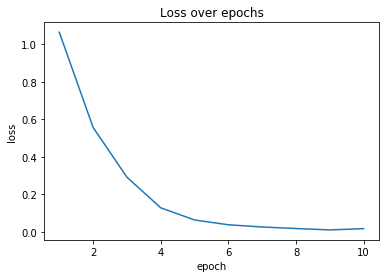

In [155]:
epoch_range = [i+1 for i in range(epochs)]
plt.plot(epoch_range, history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss over epochs')
plt.show()

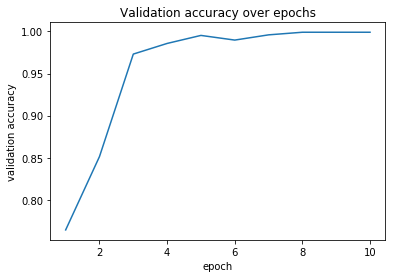

In [162]:
plt.plot(epoch_range, history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('Validation accuracy over epochs')
plt.show()

In [156]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(labels_true, labels_pred, classes, normalize=False):
    title='Confusion matrix'
    cm = confusion_matrix(labels_true, labels_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [157]:
y_pred = ar.predict_classes(x_test) # Make predictions with the trained model

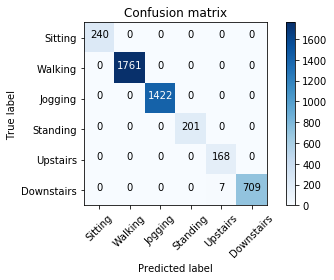

In [161]:
plot_confusion_matrix(y_test, y_pred, ['Sitting', 'Walking', 'Jogging', 'Standing', 'Upstairs', 'Downstairs'])

In [159]:
# Try out the model on the test data using Keras' model method, evaluate
scores = ar.evaluate(x_test, y_test_1hot)
print("\n%s: %.2f%%" % (ar.metrics_names[1], scores[1]*100))

4508/4508 [==============================] - 1s 142us/step

acc: 99.84%


In [160]:
# Save the model!
from keras.models import load_model
ar.save('activity_recognizer_6.h5')

## Data augmentation

There are about 1/6 as many Sitting samples as there are Jogging samples, the activity we're trying to classify with the next largest number of samples.

A potential problem that can arise from an imbalance in the number of samples of these activities is overfitting: with relatively few training examples to learn the notion of what Sitting is in terms of accelerometer data, the neural network risks thinking that all sitting looks like these training samples.

One method of dealing with this is "weighting" the samples differently by under-sampling them (i.e., under-sample the Jogging and Walking data so that there are the same number of samples for each class). However, this effectively throws out a lot of good data that could have otherwise been used to improve the model's generalization. 

Instead, we can consider the approach of data augmentation: transforming existing data in a way that's interpretation-invariant to the network to "forge" new samples. For example, in image classification, given pictures of birds of different species, you might have to distinguish between the species. But you could have 1,000 pigeon pictures, 1,000 blue jay pictures, and only 1 picture of a very rare bird. Using data augmentation, you could apply transformations to that 1 picture of the rare bird that preserve the "meaning" of the picture (so that it's still clear to the network that it's a picture of the rare species) such as mirroring it, cropping it, scaling it, or any combination of such transformations.

However, certain conditions need to be kept in mind when deciding how to perform data augmentation on time-series accelerometer data measuring different activities. There is literature on using data augmentation on time-series CNNs for forecasting [2], but the approaches outlined therein (involving time-scaling slices of the data, for example) are not readily applicable to the inherently periodic nature of the sensor data we are working with; ignoring the periodic nature of the sensor data (walking and jogging have certain rhythms over time) can lead to fabrication of data that is NOT representative of its respective activity.

Taking this into account, the methods developed in [3] can be of use for sensor time-series data in particular. The idea is that as a subject does the activities with a phone in their pocket, it may shift around and rotate along the x-axis (facing the inside or outside of the leg). Then, by rotating all 3 dimensions of the sensor data to simulate such natural displacements, we can simultaneously create new data samples, improve generalization to different shifts in phone orientation, and respect the physical constraints of the sensing system (random noise being added to the data may create physically improbable scenarios). 